In [1]:
import sys
sys.path.append('./drive/My Drive/Colab Notebooks/neuroevolution_toolbox/')
import numpy as np
import pandas as pd
import optimize
import nnet
import pickle
import matplotlib.pyplot as plt
root_dir = './drive/My Drive/Colab Notebooks/neuroevolution_toolbox/'

In [2]:
#что на входе, что на выходе? На входе батч из рядов. На выходе батч из рядов такой же длины.
#Сценарии fit: прогноз последней точки, прогноз всех

In [3]:
X = []
Y = []
for x_num in range(500):
  x = (np.random.rand(20,2)-0.5)*2
  y = np.cumsum(x,axis=0)
  X.append(x)
  Y.append(y)
X = np.array(X)
Y = np.array(Y)
print(np.shape(X),np.shape(Y))

(500, 20, 2) (500, 20, 2)


In [4]:
np.random.seed(6)
layers_desc = [{'type':'gru','out':20,'cells':50,'activation':'logtan'},
                {'type':'gru','out':2,'cells':2,'activation':'lrelu'}]
model = nnet.np_nn(layers_desc=layers_desc,in_size=2)
Y_pred=model.predict(np.array(X))
print(np.shape(Y_pred))

(500, 20, 2)


In [5]:
Y_pred[90]

array([[-2.1410193e-05,  6.3367980e-03],
       [-2.1339363e-05,  6.4141829e-03],
       [-2.1526765e-05,  6.2514050e-03],
       [-2.1659473e-05,  6.1430740e-03],
       [-2.1356929e-05,  6.3853003e-03],
       [-2.1520631e-05,  6.2654195e-03],
       [-2.1359969e-05,  6.3756718e-03],
       [-2.1497373e-05,  6.2538800e-03],
       [-2.1571946e-05,  6.2248921e-03],
       [-2.1386417e-05,  6.3536707e-03],
       [-2.1644782e-05,  6.1399471e-03],
       [-2.1606924e-05,  6.1792112e-03],
       [-2.1390208e-05,  6.3721202e-03],
       [-2.1447368e-05,  6.3146683e-03],
       [-2.1659267e-05,  6.1353091e-03],
       [-2.1563739e-05,  6.2348163e-03],
       [-2.1418971e-05,  6.3440115e-03],
       [-2.1632719e-05,  6.1543016e-03],
       [-2.1367350e-05,  6.3695698e-03],
       [-2.1419206e-05,  6.3427864e-03]], dtype=float32)

In [6]:
class trainer():
  def __init__(self,model,metric='mse',mode='full',workers=1,l2=0.00000001):
    self.workers=workers
    self.model=model
    self.metric=metric
    self.mode=mode
    #full - seq->seq прогноз, в параллель. 
    #last - seq->1, после
    #autoregression - seq->1, затем подать этот 1 на вход, затем ещё так и так далее. Пока не реализовано.
    self.opt=None
    self.genom=model.disassemble_genom()
    self.l2=l2
  def calc_metric(self,predict,fact):
    if self.metric=='mae':
      err = np.mean(np.abs(predict-fact))
    elif self.metric=='mse':
      err = np.mean((predict-fact)**2)
    elif self.metric=='rmse':
      err = np.sqrt(np.mean((predict-fact)**2))
    return err
  def estimate(self,model,X,Y):
    Y_pred = model.predict(X)
    if self.mode=='full':
      return self.calc_metric(Y_pred,Y)
    elif self.mode=='last':
      return self.calc_metric(Y_pred[:,-1,:],Y[:,-1,:])
  def estimate_genom(self,genom):
    layers_desc = self.model.layers_desc
    cur_model = nnet.np_nn(layers_desc=layers_desc,in_size=np.shape(self.X)[2])
    cur_model.assemble_genom(genom)
    err = self.estimate(cur_model,self.X,self.Y)
    reg = self.l2*np.sum(genom**2)
    return -err+reg
  def fit(self,X,Y,tacts=3):
    self.X=X
    self.Y=Y
    if self.opt is None:
      self.opt = optimize.optimizer(self.estimate_genom, genom_size=len(self.genom),parallel_cores=self.workers)
    for t in range(tacts):
      print('opt#',t)
      self.opt.optimize()
      self.genom = self.opt.best_genoms[-1]
      self.model.assemble_genom(self.genom)
      current_loss = self.opt.function(self.genom)#, test_set=True)
      print('current loss =',current_loss)

In [7]:
tr = trainer(model,metric='mae',l2=0.00001)

In [8]:
tr.fit(X,Y,tacts=240)

opt# 0
random trial
scores for optimizers augmented [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]
chosen gradient_slow_20 previous_result: nan per tacts: nan


./drive/My Drive/Colab Notebooks/neuroevolution_toolbox/optimize.py:35: RuntimeWarning: Mean of empty slice
  mx.append(np.nanmean(self.history_gain[opt_name])-time_penalty*np.nanmean(self.history_time[opt_name]))
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


score_new -1.4089836740154171 score_prev -1.4089836740154171
score_new -1.4089836740154171 score_prev -1.4089836740154171
score_new -1.4089836740154171 score_prev -1.4089836740154171
score_new -1.4089836740154171 score_prev -1.4089836740154171
result gradient_slow_20 previous_gain: nan per tacts: nan duration 0 days 00:03:01.490160
current loss = -1.4089836740154171
opt# 1
scores for optimizers augmented [ 1.0e+10  1.0e+10  1.0e+10  1.0e+10 -4.2e-02  1.0e+10  1.0e+10]
chosen evol_wide previous_result: nan per tacts: nan
iteration 0 y= [-1.39460512 -1.39579484 -1.39598833]
iteration 1 y= [-1.39460512 -1.39576107 -1.39577309]
iteration 2 y= [-1.39460512 -1.3953233  -1.39572644]
iteration 3 y= [-1.3813829  -1.39460512 -1.39517746]
iteration final y= [-1.3813829  -1.39345887 -1.39364786]
result evol_wide previous_gain: nan per tacts: nan duration 0 days 00:04:43.535019
current loss = -1.3813828995738353
opt# 2
scores for optimizers augmented [-1.48992256e-02  1.00000000e+10  1.00000000e+10

Process ForkPoolWorker-578:


KeyboardInterrupt: ignored

Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "<ipython-input-6-630bc769d078>", line 31, in estimate_genom
    err = self.estimate(cur_model,self.X,self.Y)
  File "<ipython-input-6-630bc769d078>", line 22, in estimate
    Y_pred = model.predict(X)
  File "./drive/My Drive/Colab Notebooks/neuroevolution_toolbox/nnet.py", line 229, in predict
    return np.array([self.predict_sequence(x[i]) for i in range(np.shape(x)[0])])
  File "./drive/My Drive/Colab Notebooks/neuroevolution_toolbox/nnet.py", line 229, in <listcomp>
    return np.array([self.predict_sequence(x[i]) for 

In [ ]:
tr.opt.history_gain['evol_mid_chaos']

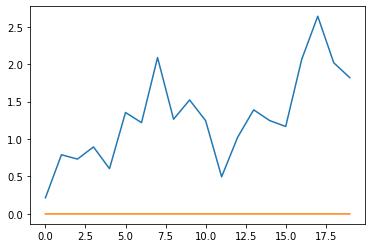

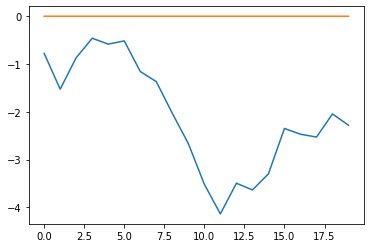

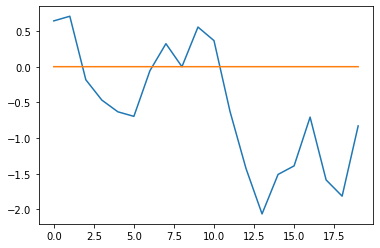

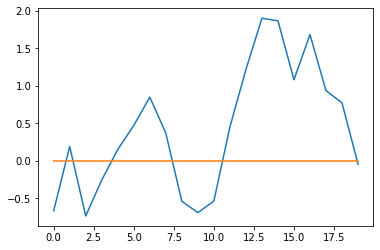

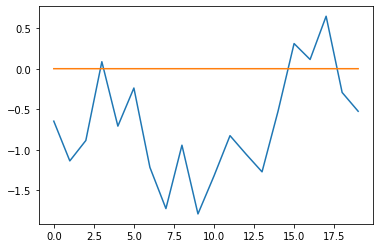

In [9]:
Y_pred=model.predict(np.array(X))
for i in [2,9,25,60,90]:
  plt.plot(Y[i,:,0])
  plt.plot(Y_pred[i,:,0])
  plt.show()